In [1]:
import numpy as np
import h5py
import json
import sys
sys.path.append('/home/zhouzb/')
import illustris_python as il
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def xyline(x, y):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments


def LoadMergHist(simu, subhaloID):
    '''
    return subhalo's main progenitor and merger history with snapshot
    '''
    if (simu == 'TNG') or (simu == 'tng'):
        ldir = '/Raid0/zhouzb/localRUN/tng_DiskMerTree/%d.json' % subhaloID
    else:
        ldir = '/Raid0/zhouzb/localRUN/il1_DiskMerTree/%d.json' % subhaloID
    
    with open(ldir) as f:
        data = json.load(f)
    
    Main = np.array(data['Main'])
    return dict(zip(Main[:, 0], Main[:, 1])), np.array(data['Mergers'])

def HistValAndBin(nums, bins, more=0, mask=0):
    if mask == 1:
        reMask = []

    val = []
    tmp = nums[nums < bins[1]]
    if mask == 1:
        reMask.append(nums < bins[1])
    val.append(len(tmp))

    for i in range(1,len(bins)-1):
        tmp = nums[(nums > bins[i]) & (nums <= bins[i+1])]
        val.append(len(tmp))
        if mask == 1:
            reMask.append((nums > bins[i]) & (nums <= bins[i+1]))

    if more == 1:
        tmp = nums[nums > bins[-1]]
        val.append(len(tmp))
        if mask == 1:
            reMask.append(nums > bins[-1])

    if mask == 0:
        return np.array(val)
    else:
        return np.array(val), np.array(reMask)

def ErrorBarMedian(data):
    #return 25%, 50%, 75%
    if len(data) == 0:
        return 0, 0, 0
    elif len(data) < 3:
        return 0, np.median(data), 0
    else:
        data.sort()
        return data[int(len(data) / 4)], np.median(data), data[int(len(data) * 0.75)]

def Ydata(simu, ids, rawdata, SnapList, Redshift):
    dataWithZ = {}
    for x in Redshift:
        dataWithZ[x] = []
    #all each halo's information into 'dataWithZ'
    for subID in ids:
        data = []
        prog = LoadMergHist(simu, subID)[0]
        plot = 1
        for snap in SnapList:
            try:
                haloID = prog[snap]
                data.append(rawdata[snap][haloID])
            except:
                plot = 0       
            
        if plot:
            for i in range(len(data)):
                dataWithZ[Redshift[i]].append(data[i])

    #calculate Error bar
    plotdata = [[], [], []]
    for i in range(len(data)):
        d0, d1, d2 = ErrorBarMedian(dataWithZ[Redshift[i]])
        plotdata[0].append(d0)
        plotdata[1].append(d1)
        plotdata[2].append(d2)
    plotdata = np.array(plotdata)
    Err = np.vstack((plotdata[1,:] - plotdata[0,:], plotdata[2,:] - plotdata[1,:]))
    return plotdata[1,:], Err

def findGid(simu, snap, ids):
    res = []
    GID = il.func.loadSubhalos(simu, snap, 'SubhaloGrNr')
    for haloID in ids:
        try:
            prog = LoadMergHist(simu, haloID)[0]
            subID = prog[snap]
        except:
            continue

        res.append(GID[subID])
    return np.unique(res)

def logmas(data):
    if type(data) != type(np.array(0)):
        data = np.array(data)
    data = np.log10(data * 10 ** 10)
    data[np.isinf(data)] = 0
    data[np.isnan(data)] = 0
    return data

def getMultiData(simu, snapList, fields, haloType):
    res = []
    for i in range(len(fields)):
        res.append({})
    for snap in snapList:
        if haloType == 'fof':
            tmp = il.func.loadhalos(simu, snap, fields)
        else:
            tmp = il.func.loadSubhalos(simu, snap, fields)
        for i in range(len(fields)):
            res[i][snap] = tmp[fields[i]]
    return res

def getData(simu, snapList, fields, haloType):
    raw = {}
    for snap in snapList:
        if haloType == 'fof':
            tmp = il.func.loadhalos(simu, snap, fields)
        else:
            tmp = il.func.loadSubhalos(simu, snap, fields)
        raw[snap] = tmp[i]
    return raw

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap


def xyline(x, y):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

In [2]:
rs = np.array([0, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0])
il1_snap = [135, 120, 108, 95, 85, 75, 68, 64, 60]
tng_snap = [99, 84, 67, 59, 50, 40, 33, 29, 25]

In [3]:
tng_BHMass = {}
tng_BHdot = {}

tng_MgasDivSFR = {}
tng_sSFR = {}
tng_SFR = {}
tng_GF = {}


for snap in tng_snap:
    BHmas = il.func.loadSubhalos('TNG', snap, 'SubhaloBHMass')
    dot = il.func.loadSubhalos('TNG', snap, 'SubhaloBHMdot')
    tng_BHMass[snap] = BHmas / 0.6774
    tng_BHdot[snap] = dot

    sfr = il.func.loadSubhalos('TNG', snap, 'SubhaloSFR') 
    mass = il.func.loadSubhalos('TNG', snap, 'SubhaloMassType') * 10**10 / 0.6774
    MgasDivSFR = mass[:, 0] / sfr
    MgasDivSFR[np.isinf(MgasDivSFR)] = 0
    MgasDivSFR[np.isnan(MgasDivSFR)] = 0
    
    sSFR = sfr / mass[:, 4]
    sSFR[np.isinf(sSFR)] = 0
    sSFR[np.isnan(sSFR)] = 0
    mas = il.func.loadSubhalos('TNG', snap, 'SubhaloMassInHalfRadType')
    
    Gf = mas[:, 0] / (mas[:, 4] + mas[:, 0])
    Gf[np.isnan(Gf)] = 0
    
    tng_GF[snap] = Gf
    tng_SFR[snap] = sfr
    tng_sSFR[snap] = sSFR
    tng_MgasDivSFR[snap] = MgasDivSFR

/home/zhouzb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/zhouzb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/zhouzb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/home/zhouzb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/zhouzb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


In [44]:
tng_log_BHmass = {}
for snap in tng_BHMass.keys():
    tng_log_BHmass[snap] = logmas(tng_BHMass[snap])
    

/home/zhouzb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in log10


In [24]:
il1_BHMass = {}
il1_BHdot = {}

il1_MgasDivSFR = {}
il1_sSFR = {}
il1_SFR = {}
il1_GF = {}

for snap in il1_snap:
    mas = il.func.loadSubhalos('il1', snap, 'SubhaloBHMass')
    dot = il.func.loadSubhalos('il1', snap, 'SubhaloBHMdot')
    il1_BHMass[snap] = mas / 0.704
    il1_BHdot[snap] = dot
    
    sfr = il.func.loadSubhalos('il1', snap, 'SubhaloSFR')
    mass = il.func.loadSubhalos('il1', snap, 'SubhaloMassType') * 10**10 / 0.704
    MgasDivSFR = mass[:, 0] / sfr
    MgasDivSFR[np.isinf(MgasDivSFR)] = 0
    MgasDivSFR[np.isnan(MgasDivSFR)] = 0
    
    sSFR = sfr / mass[:, 4]
    sSFR[np.isinf(sSFR)] = 0
    sSFR[np.isnan(sSFR)] = 0
    mas = il.func.loadSubhalos('il1', snap, 'SubhaloMassInHalfRadType')
    
    Gf = mas[:, 0] / (mas[:, 4] + mas[:, 0])
    Gf[np.isnan(Gf)] = 0
    
    il1_GF[snap] = Gf
    il1_SFR[snap] = sfr
    il1_sSFR[snap] = sSFR
    il1_MgasDivSFR[snap] = MgasDivSFR

/home/zhouzb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/home/zhouzb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/zhouzb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/zhouzb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/zhouzb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


In [46]:
il1_log_BHmass = {}
for snap in il1_BHMass.keys():
    il1_log_BHmass[snap] = logmas(il1_BHMass[snap])

/home/zhouzb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in log10


In [7]:
il1_barID = np.load('/Raid0/zhouzb/localRUN/barredID_il1.npy')
il1_diskID = np.load('/Raid0/zhouzb/localRUN/diskID_il1.npy')

tng_barID = np.load('/Raid0/zhouzb/localRUN/barredID_4WP_TNG.npy')
tng_diskID = np.load('/Raid0/zhouzb/localRUN/diskID_4WP.npy')

In [8]:
tng_unbar = []
for i in tng_diskID:
    if i not in tng_barID:
        tng_unbar.append(i)
        
il1_unbar = []
for i in il1_diskID:
    if i not in il1_barID:
        il1_unbar.append(i)
        
tng_unbar = np.array(tng_unbar)
il1_unbar = np.array(il1_unbar)

In [9]:
#Separate haloID by mass bins
il1_sMass = logmas(il.func.loadSubhalos('il1', 135, 'SubhaloMassType')[:, 4] / 0.704)
tng_sMass = logmas(il.func.loadSubhalos('TNG', 99, 'SubhaloMassType')[:, 4] / 0.6774)

/home/zhouzb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in log10


#----------------Mass Bin: [10.5, 11], [11, ~)---------------

#----------------FIG: M_dot / M_bh vs. SFR----------------

In [12]:
#M_dot / M_bh vs. SFR
il1_Y_Mdot, il1_Err = Ydata('il1', il1_barID, il1_BHdot, il1_snap, rs)
il1_Y_Mdot_2, il1_Err_2 = Ydata('il1', il1_unbar, il1_BHdot, il1_snap, rs)

il1_Y_M, il1_Err = Ydata('il1', il1_barID, il1_BHMass, il1_snap, rs)
il1_Y_M_2, il1_Err_2 = Ydata('il1', il1_unbar, il1_BHMass, il1_snap, rs)

il1_X_SFR, il1_Err_SFR = Ydata('il1', il1_barID, il1_SFR, il1_snap, rs)
il1_X_SFR_2, il1_Err_SFR_2 = Ydata('il1', il1_unbar, il1_SFR, il1_snap, rs)


tng_Y_Mdot, tng_Err = Ydata('TNG', tng_barID, tng_BHdot, tng_snap, rs)
tng_Y_Mdot_2, tng_Err_2 = Ydata('TNG', tng_unbar, tng_BHdot, tng_snap, rs)

tng_Y_M, tng_Err = Ydata('TNG', tng_barID, tng_BHMass, tng_snap, rs)
tng_Y_M_2, tng_Err_2 = Ydata('TNG', tng_unbar, tng_BHMass, tng_snap, rs)

tng_X_SFR, tng_Err_SFR = Ydata('TNG', tng_barID, tng_SFR, tng_snap, rs)
tng_X_SFR_2, tng_Err_SFR_2 = Ydata('TNG', tng_unbar, tng_SFR, tng_snap, rs)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [13]:
def colorline(x, y, linestyles, label):
    norm = plt.Normalize(0, 3)
    color = rs
    
    seg = xyline(il1_Y_Mdot / il1_Y_M, il1_X_SFR)
    # 'solid' | 'dashed' | 'dashdot' | 'dotted
    lc = LineCollection(seg, cmap='rainbow', norm=norm, linestyles=linestyles, label=label)
    lc.set_array(np.array(color))
    return lc

In [14]:
def sepaByBins(simu, bins, bValue, haloID, data, snapList, rs):
    #Select IDs in each bins, return ordered by barred -> unbarred / small -> big
    idList = []
    for i in range(len(bins)-1):
        left = bins[i]
        right = bins[i+1]
        #haloID : [[barredID], [unbarredID]]
        for ids in haloID:
            idList.append(ids[(bValue[ids] >= left) & (bValue[ids] < right)])
    
    res = []
    for ids in idList:
        res.append(Ydata(simu, ids, data, snapList, rs)[0])
    return np.array(res)

In [50]:
#----------------Mass Bin: [10.5, 11], [11, ~)---------------
il1_BHdot_data = sepaByBins('il1', [10.5, 11, 15], il1_sMass, [il1_barID, il1_unbar], il1_BHdot, il1_snap, rs)
il1_BHMass_data = sepaByBins('il1', [10.5, 11, 15], il1_sMass, [il1_barID, il1_unbar], il1_BHMass, il1_snap, rs)
il1_SFR_data = sepaByBins('il1', [10.5, 11, 15], il1_sMass, [il1_barID, il1_unbar], il1_SFR, il1_snap, rs)
il1_sSFR_data = sepaByBins('il1', [10.5, 11, 15], il1_sMass, [il1_barID, il1_unbar], il1_sSFR, il1_snap, rs)
il1_GF_data = sepaByBins('il1', [10.5, 11, 15], il1_sMass, [il1_barID, il1_unbar], il1_GF, il1_snap, rs)
    
tng_BHdot_data = sepaByBins('TNG', [10.5, 11, 15], tng_sMass, [tng_barID, tng_unbar], tng_BHdot, tng_snap, rs)
tng_BHMass_data = sepaByBins('TNG', [10.5, 11, 15], tng_sMass, [tng_barID, tng_unbar], tng_BHMass, tng_snap, rs)
tng_SFR_data = sepaByBins('TNG', [10.5, 11, 15], tng_sMass, [tng_barID, tng_unbar], tng_SFR, tng_snap, rs)  
tng_sSFR_data = sepaByBins('TNG', [10.5, 11, 15], tng_sMass, [tng_barID, tng_unbar], tng_sSFR, tng_snap, rs)  
tng_GF_data = sepaByBins('TNG', [10.5, 11, 15], tng_sMass, [tng_barID, tng_unbar], tng_GF, tng_snap, rs)  

In [51]:
il1_log_BHMass_data = sepaByBins('il1', [10.5, 11, 15], il1_sMass, [il1_barID, il1_unbar], il1_log_BHmass, il1_snap, rs)
tng_log_BHMass_data = sepaByBins('TNG', [10.5, 11, 15], tng_sMass, [tng_barID, tng_unbar], tng_log_BHmass, tng_snap, rs)

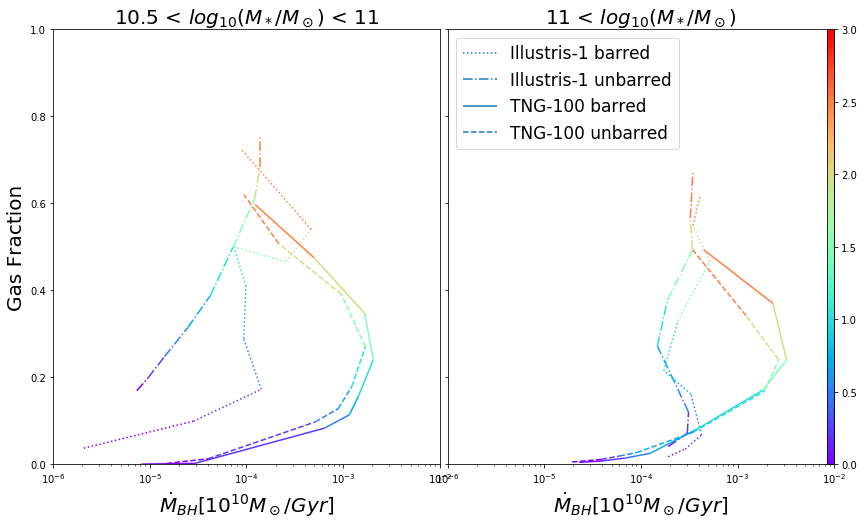

In [30]:
#BHdot vs. GF
norm = plt.Normalize(0, 3)
color = rs

fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(14, 8))

for massBin in range(2):
    lc1 = LineCollection(xyline(il1_BHdot_data[0+2*massBin], il1_GF_data[0+2*massBin]), cmap='rainbow', norm=norm, linestyles='dotted', label='Illustris-1 barred')
    lc1.set_array(np.array(color))
    line = ax[massBin].add_collection(lc1)
    
    lc2 = LineCollection(xyline(il1_BHdot_data[1+2*massBin], il1_GF_data[1+2*massBin]), cmap='rainbow', norm=norm, linestyles='dashdot', label='Illustris-1 unbarred')
    lc2.set_array(np.array(color))
    line = ax[massBin].add_collection(lc2)
    
    lc3 = LineCollection(xyline(tng_BHdot_data[0+2*massBin], tng_GF_data[0+2*massBin]), cmap='rainbow', norm=norm, linestyles='solid', label='TNG-100 barred')
    lc3.set_array(np.array(color))
    line = ax[massBin].add_collection(lc3)
    
    lc4 = LineCollection(xyline(tng_BHdot_data[1+2*massBin], tng_GF_data[1+2*massBin]), cmap='rainbow', norm=norm, linestyles='dashed', label='TNG-100 unbarred')
    lc4.set_array(np.array(color))
    line = ax[massBin].add_collection(lc4)
    

    
    ax[massBin].set_xscale('log')
    ax[massBin].set_xlabel(r'$\dot{M}_{BH}[10^{10} M_\odot / Gyr]$', fontsize=20)
    ax[massBin].set_xlim(0.000001, 0.01)
    ax[massBin].set_ylim(0,1)

ax[1].legend(loc = 2, fontsize=17)
ax[0].set_ylabel(r'Gas Fraction', fontsize=20)
ax[0].set_title(r'10.5 < $log_{10}({M_*}/M_\odot)$ < 11', fontsize=20)
ax[1].set_title(r'11 < $log_{10}({M_*}/M_\odot)$', fontsize=20)

# ax[1].text(25, 17, r'Redshift $z$', horizontalalignment='left', verticalalignment='center', rotation='vertical', fontsize=20)

# fig.tight_layout()
axins = inset_axes(ax[1],
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower right',
                   bbox_to_anchor=(0., 0, 1.0, 1.0),    #(x, y, wide, height)
                   bbox_transform=ax[1].transAxes,
                   borderpad=0,
                   )
fig.colorbar(line, cax=axins)
plt.subplots_adjust(wspace = 0.02, hspace =0)

plt.savefig('/Raid0/zhouzb/result_V2/BHdot_GF_colorline.pdf')
plt.savefig('./figs/BHdot_GF_colorline.png')

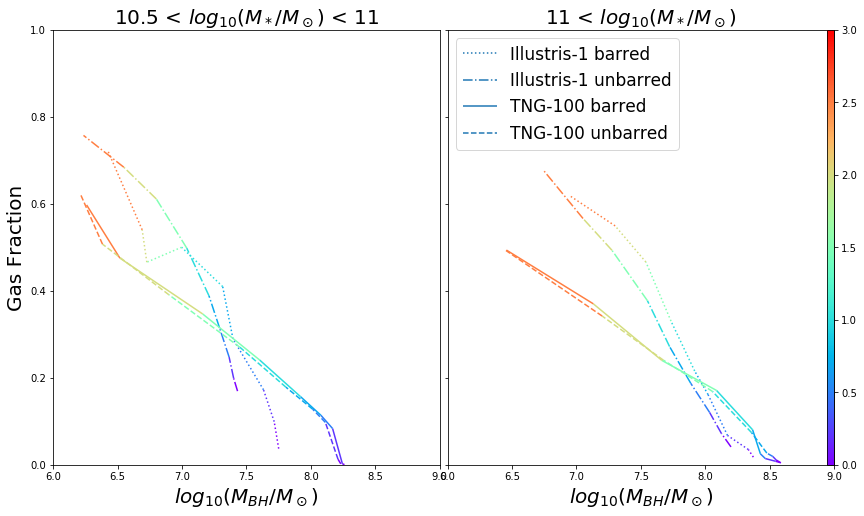

In [55]:
#BHMass vs. GF
norm = plt.Normalize(0, 3)
color = rs

fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(14, 8))

for massBin in range(2):
    lc1 = LineCollection(xyline(il1_log_BHMass_data[0+2*massBin], il1_GF_data[0+2*massBin]), cmap='rainbow', norm=norm, linestyles='dotted', label='Illustris-1 barred')
    lc1.set_array(np.array(color))
    line = ax[massBin].add_collection(lc1)
    
    lc2 = LineCollection(xyline(il1_log_BHMass_data[1+2*massBin], il1_GF_data[1+2*massBin]), cmap='rainbow', norm=norm, linestyles='dashdot', label='Illustris-1 unbarred')
    lc2.set_array(np.array(color))
    line = ax[massBin].add_collection(lc2)
    
    lc3 = LineCollection(xyline(tng_log_BHMass_data[0+2*massBin], tng_GF_data[0+2*massBin]), cmap='rainbow', norm=norm, linestyles='solid', label='TNG-100 barred')
    lc3.set_array(np.array(color))
    line = ax[massBin].add_collection(lc3)
    
    lc4 = LineCollection(xyline(tng_log_BHMass_data[1+2*massBin], tng_GF_data[1+2*massBin]), cmap='rainbow', norm=norm, linestyles='dashed', label='TNG-100 unbarred')
    lc4.set_array(np.array(color))
    line = ax[massBin].add_collection(lc4)
    

    
#     ax[massBin].set_xscale('log')
    ax[massBin].set_xlabel(r'$log_{10}(M_{BH}/M_\odot)$', fontsize=20)
    ax[massBin].set_xlim(6,9)
    ax[massBin].set_ylim(0,1)

ax[1].legend(loc = 2, fontsize=17)
ax[0].set_ylabel(r'Gas Fraction', fontsize=20)
ax[0].set_title(r'10.5 < $log_{10}({M_*}/M_\odot)$ < 11', fontsize=20)
ax[1].set_title(r'11 < $log_{10}({M_*}/M_\odot)$', fontsize=20)

# ax[1].text(25, 17, r'Redshift $z$', horizontalalignment='left', verticalalignment='center', rotation='vertical', fontsize=20)

# fig.tight_layout()
axins = inset_axes(ax[1],
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower right',
                   bbox_to_anchor=(0., 0, 1.0, 1.0),    #(x, y, wide, height)
                   bbox_transform=ax[1].transAxes,
                   borderpad=0,
                   )
fig.colorbar(line, cax=axins)
plt.subplots_adjust(wspace = 0.02, hspace =0)

plt.savefig('/Raid0/zhouzb/result_V2/BHMass_GF_colorline.pdf')
plt.savefig('./figs/BHMass_GF_colorline.png')

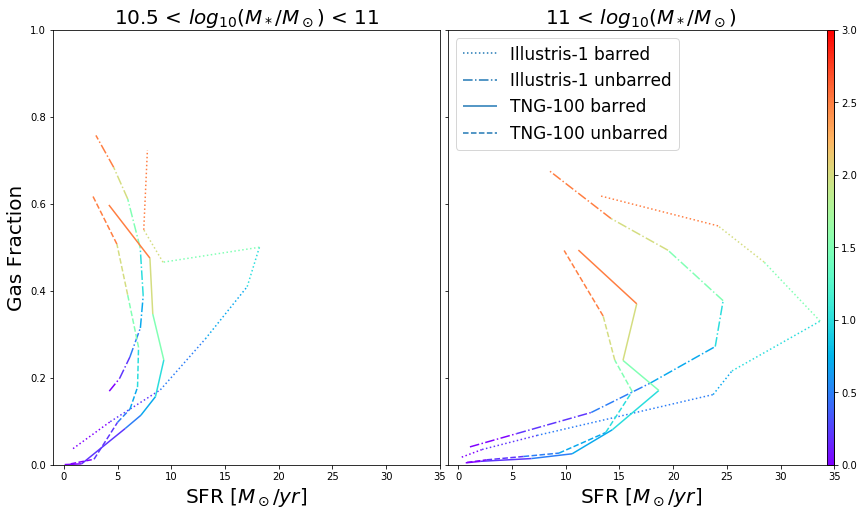

In [57]:
#SFR vs. GF
norm = plt.Normalize(0, 3)
color = rs

fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(14, 8))

for massBin in range(2):
    lc1 = LineCollection(xyline(il1_SFR_data[0+2*massBin], il1_GF_data[0+2*massBin]), cmap='rainbow', norm=norm, linestyles='dotted', label='Illustris-1 barred')
    lc1.set_array(np.array(color))
    line = ax[massBin].add_collection(lc1)
    
    lc2 = LineCollection(xyline(il1_SFR_data[1+2*massBin], il1_GF_data[1+2*massBin]), cmap='rainbow', norm=norm, linestyles='dashdot', label='Illustris-1 unbarred')
    lc2.set_array(np.array(color))
    line = ax[massBin].add_collection(lc2)
    
    lc3 = LineCollection(xyline(tng_SFR_data[0+2*massBin], tng_GF_data[0+2*massBin]), cmap='rainbow', norm=norm, linestyles='solid', label='TNG-100 barred')
    lc3.set_array(np.array(color))
    line = ax[massBin].add_collection(lc3)
    
    lc4 = LineCollection(xyline(tng_SFR_data[1+2*massBin], tng_GF_data[1+2*massBin]), cmap='rainbow', norm=norm, linestyles='dashed', label='TNG-100 unbarred')
    lc4.set_array(np.array(color))
    line = ax[massBin].add_collection(lc4)
    

    
#     ax[massBin].set_xscale('log')
    ax[massBin].set_xlabel(r'SFR [$M_\odot/yr$]', fontsize=20)
    ax[massBin].set_xlim(-1, 35)
    ax[massBin].set_ylim(0, 1)

ax[1].legend(loc = 2, fontsize=17)
ax[0].set_ylabel(r'Gas Fraction', fontsize=20)
ax[0].set_title(r'10.5 < $log_{10}({M_*}/M_\odot)$ < 11', fontsize=20)
ax[1].set_title(r'11 < $log_{10}({M_*}/M_\odot)$', fontsize=20)

# ax[1].text(25, 17, r'Redshift $z$', horizontalalignment='left', verticalalignment='center', rotation='vertical', fontsize=20)

# fig.tight_layout()
axins = inset_axes(ax[1],
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower right',
                   bbox_to_anchor=(0., 0, 1.0, 1.0),    #(x, y, wide, height)
                   bbox_transform=ax[1].transAxes,
                   borderpad=0,
                   )
fig.colorbar(line, cax=axins)
plt.subplots_adjust(wspace = 0.02, hspace =0)

plt.savefig('/Raid0/zhouzb/result_V2/SFR_GF_colorline.pdf')
plt.savefig('./figs/SFR_GF_colorline.png')

In [199]:
il1_sSFR_data

array([[9.40198982e-12, 5.30097810e-11, 1.23482996e-10, 1.98863869e-10,
        3.99853338e-10, 7.02068178e-10, 8.33718052e-10, 1.30273907e-09,
        2.20180710e-09],
       [7.84456042e-11, 1.14164844e-10, 1.69866742e-10, 2.54823322e-10,
        3.68771992e-10, 6.10103904e-10, 9.69044964e-10, 1.34393637e-09,
        1.81333385e-09],
       [1.77966725e-12, 9.23179426e-12, 4.24419428e-11, 1.74201683e-10,
        2.71499449e-10, 5.89202094e-10, 9.42573913e-10, 1.32935534e-09,
        1.84520900e-09],
       [6.71925692e-12, 3.83253312e-11, 9.10556243e-11, 2.03459738e-10,
        3.54009053e-10, 6.28370333e-10, 9.98023933e-10, 1.30444285e-09,
        1.83546616e-09]])

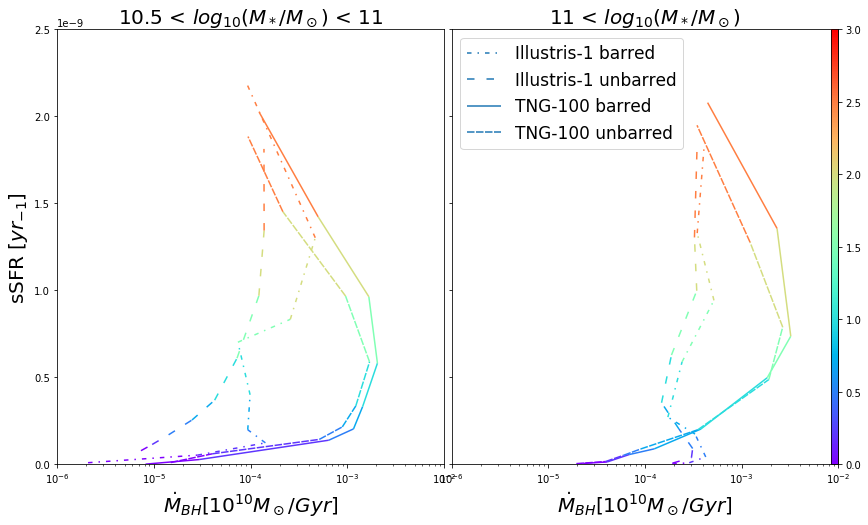

In [215]:
#Mdot vs sSFR

fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(14, 8))

for massBin in range(2):
    lc1 = LineCollection(xyline(il1_BHdot_data[0+2*massBin], il1_sSFR_data[0+2*massBin]), cmap='rainbow', norm=norm, linestyles= (0, (3, 4, 1, 4)), label='Illustris-1 barred')
    lc1.set_array(np.array(color))
#     lc1.set_linewidth(2.5)
    line = ax[massBin].add_collection(lc1)
    
    lc2 = LineCollection(xyline(il1_BHdot_data[1+2*massBin], il1_sSFR_data[1+2*massBin]), cmap='rainbow', norm=norm, linestyles= (0, (5, 8)), label='Illustris-1 unbarred')
    lc2.set_array(np.array(color))
#     lc2.set_linewidth(2.5)
    line = ax[massBin].add_collection(lc2)
    
    lc3 = LineCollection(xyline(tng_BHdot_data[0+2*massBin], tng_sSFR_data[0+2*massBin]), cmap='rainbow', norm=norm, linestyles='solid', label='TNG-100 barred')
    lc3.set_array(np.array(color))
#     lc3.set_linewidth(2.5)
    line = ax[massBin].add_collection(lc3)
    
    lc4 = LineCollection(xyline(tng_BHdot_data[1+2*massBin], tng_sSFR_data[1+2*massBin]), cmap='rainbow', norm=norm, linestyles=(0, (5, 1)), label='TNG-100 unbarred')
    lc4.set_array(np.array(color))
#     lc4.set_linewidth(2.5)
    line = ax[massBin].add_collection(lc4)
    

    
    ax[massBin].set_xscale('log')
    ax[massBin].set_xlabel(r'$\dot{M}_{BH}[10^{10} M_\odot / Gyr]$', fontsize=20)
    ax[massBin].set_xlim(0.000001, 0.01)
    ax[massBin].set_ylim(0, 0.0000000025)

ax[1].legend(loc = 2, fontsize=17)
ax[0].set_ylabel(r'sSFR [$yr_{-1}$]', fontsize=20)
ax[0].set_title(r'10.5 < $log_{10}({M_*}/M_\odot)$ < 11', fontsize=20)
ax[1].set_title(r'11 < $log_{10}({M_*}/M_\odot)$', fontsize=20)

# ax[1].text(0.025, 17, r'Redshift $z$', horizontalalignment='left', verticalalignment='center', rotation='vertical', fontsize=20)

# fig.tight_layout()
axins = inset_axes(ax[1],
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower right',
                   bbox_to_anchor=(0., 0, 1.0, 1.0),    #(x, y, wide, height)
                   bbox_transform=ax[1].transAxes,
                   borderpad=0,
                   )
fig.colorbar(line, cax=axins)
plt.subplots_adjust(wspace = 0.02, hspace =0)

plt.savefig('/Raid0/zhouzb/result_V2/BHdot_vs_sSFR_InBins_ColorLine.pdf')
plt.savefig('./figs/BHdot_vs_sSFR_InBins_ColorLine.png')

In [232]:
il1_log_BHMass_data

array([[7.75016853, 7.71531298, 7.63248822, 7.39557918, 7.31577421,
        6.99694395, 6.72712977, 6.69119362, 6.42235519],
       [7.43103929, 7.40090769, 7.36561235, 7.2914638 , 7.20945203,
        7.03665084, 6.8010349 , 6.54891633, 6.23599685],
       [8.3723502 , 8.33343462, 8.17160172, 8.02078082, 7.91692204,
        7.73354442, 7.53889125, 7.29998554, 6.95121727],
       [8.19873975, 8.12534401, 8.03316215, 7.88655661, 7.72237032,
        7.55046098, 7.27562119, 7.0509337 , 6.74761191]])

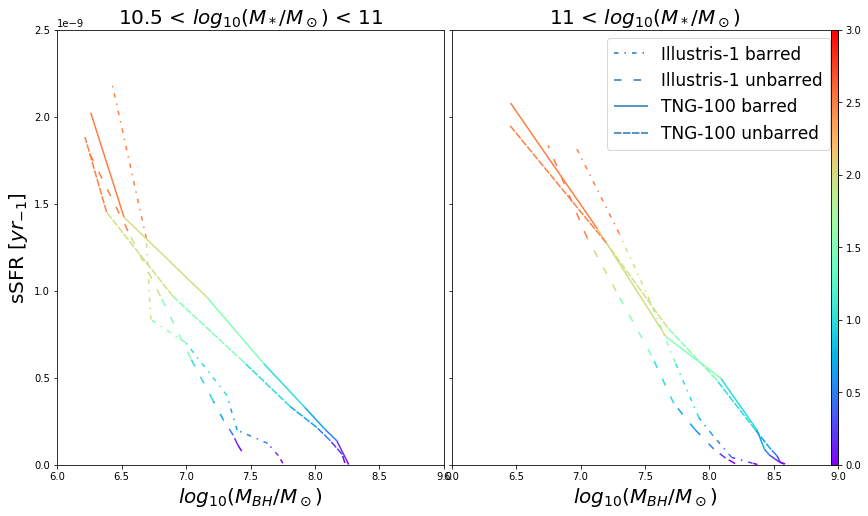

In [237]:
#BHMass vs sSFR

fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(14, 8))

for massBin in range(2):
    lc1 = LineCollection(xyline(il1_log_BHMass_data[0+2*massBin], il1_sSFR_data[0+2*massBin]), cmap='rainbow', norm=norm, linestyles= (0, (3, 4, 1, 4)), label='Illustris-1 barred')
    lc1.set_array(np.array(color))
#     lc1.set_linewidth(2.5)
    line = ax[massBin].add_collection(lc1)
    
    lc2 = LineCollection(xyline(il1_log_BHMass_data[1+2*massBin], il1_sSFR_data[1+2*massBin]), cmap='rainbow', norm=norm, linestyles= (0, (5, 8)), label='Illustris-1 unbarred')
    lc2.set_array(np.array(color))
#     lc2.set_linewidth(2.5)
    line = ax[massBin].add_collection(lc2)
    
    lc3 = LineCollection(xyline(tng_log_BHMass_data[0+2*massBin], tng_sSFR_data[0+2*massBin]), cmap='rainbow', norm=norm, linestyles='solid', label='TNG-100 barred')
    lc3.set_array(np.array(color))
#     lc3.set_linewidth(2.5)
    line = ax[massBin].add_collection(lc3)
    
    lc4 = LineCollection(xyline(tng_log_BHMass_data[1+2*massBin], tng_sSFR_data[1+2*massBin]), cmap='rainbow', norm=norm, linestyles=(0, (5, 1)), label='TNG-100 unbarred')
    lc4.set_array(np.array(color))
#     lc4.set_linewidth(2.5)
    line = ax[massBin].add_collection(lc4)
    

    
#     ax[massBin].set_xscale('log')
    ax[massBin].set_xlabel(r'$log_{10}(M_{BH}/M_\odot)$', fontsize=20)
    ax[massBin].set_xlim(6, 9)
    ax[massBin].set_ylim(0, 0.0000000025)

ax[1].legend(loc = 1, fontsize=17)
ax[0].set_ylabel(r'sSFR [$yr_{-1}$]', fontsize=20)
ax[0].set_title(r'10.5 < $log_{10}({M_*}/M_\odot)$ < 11', fontsize=20)
ax[1].set_title(r'11 < $log_{10}({M_*}/M_\odot)$', fontsize=20)



# fig.tight_layout()
axins = inset_axes(ax[1],
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower right',
                   bbox_to_anchor=(0., 0, 1.0, 1.0),    #(x, y, wide, height)
                   bbox_transform=ax[1].transAxes,
                   borderpad=0,
                   )
fig.colorbar(line, cax=axins)
plt.subplots_adjust(wspace = 0.02, hspace =0)

plt.savefig('/Raid0/zhouzb/result_V2/BHmass_vs_sSFR_InBins_ColorLine.pdf')
plt.savefig('./figs/BHmass_vs_sSFR_InBins_ColorLine.png')

In [ ]:
#----------------FIG: f_gas(z)/f_gas(z_red=3.0) ----------------

In [59]:
il1_GF_30 = {}
for snap in il1_GF.keys():
    il1_GF_30[snap] = il1_GF[snap] / il1_GF[60]

ValueError: operands could not be broadcast together with shapes (4366546,) (5611663,) 

In [62]:
il1_BHMass

{135: array([0.01202081, 0.12883317, 0.14083533, ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 120: array([0.84287125, 0.17108336, 0.09737173, ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 108: array([0.80662805, 0.10916937, 0.1135847 , ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 95: array([0.3988449 , 0.05917108, 0.06959667, ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 85: array([0.30960247, 0.13278814, 0.02869755, ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 75: array([0.16625434, 0.0486273 , 0.        , ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 68: array([1.0881103 , 0.00364138, 0.02587873, ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 64: array([0.       , 0.0017894, 0.       , ..., 0.       , 0.       ,
        0.       ], dtype=float32),
 60: array([0.03637252, 0.00918407, 0.02267573, ..., 0.        , 0.        ,
        0.    

In [73]:
def Ydata_modify(simu, ids, rawdata, SnapList, Redshift):
    if simu == 'il1':
        rs3 = 60
    else:
        rs3 = 25
        
    dataWithZ = {}
    for x in Redshift:
        dataWithZ[x] = []
    #all each halo's information into 'dataWithZ'
    for subID in ids:
        data = []
        prog = LoadMergHist(simu, subID)[0]
        plot = 1
        for snap in SnapList:
            try:
                haloID = prog[snap]
                rs3ID = prog[rs3]
                if rawdata[rs3][rs3ID] == 0:
                    data.append(0)
                else:
                    data.append(rawdata[snap][haloID] / rawdata[rs3][rs3ID])
            except:
                plot = 0       
            
        if plot:
            for i in range(len(data)):
                dataWithZ[Redshift[i]].append(data[i])

    #calculate Error bar
    plotdata = [[], [], []]
    for i in range(len(data)):
        d0, d1, d2 = ErrorBarMedian(dataWithZ[Redshift[i]])
        plotdata[0].append(d0)
        plotdata[1].append(d1)
        plotdata[2].append(d2)
    plotdata = np.array(plotdata)
    Err = np.vstack((plotdata[1,:] - plotdata[0,:], plotdata[2,:] - plotdata[1,:]))
    return plotdata[1,:], Err

def sepaByBins_modify(simu, bins, bValue, haloID, data, snapList, rs):
    #Select IDs in each bins, return ordered by barred -> unbarred / small -> big
    idList = []
    for i in range(len(bins)-1):
        left = bins[i]
        right = bins[i+1]
        #haloID : [[barredID], [unbarredID]]
        for ids in haloID:
            idList.append(ids[(bValue[ids] >= left) & (bValue[ids] < right)])
    
    res = []
    for ids in idList:
        res.append(Ydata_modify(simu, ids, data, snapList, rs)[0])
    return np.array(res)

In [76]:
il1_GF_modify_data = sepaByBins_modify('il1', [10.5, 11, 15], il1_sMass, [il1_barID, il1_unbar], il1_GF, il1_snap, rs)
tng_GF_modify_data = sepaByBins_modify('tng', [10.5, 11, 15], tng_sMass, [tng_barID, tng_unbar], tng_GF, tng_snap, rs)

In [77]:
tng_GF_modify_data

array([[0.0010067 , 0.00399554, 0.12820978, 0.18797201, 0.28267163,
        0.42223407, 0.60464251, 0.80918658, 1.        ],
       [0.00429996, 0.02404421, 0.14593282, 0.19864079, 0.28567842,
        0.45707339, 0.64289355, 0.82724047, 1.        ],
       [0.00750822, 0.01797642, 0.02938418, 0.06268588, 0.18321586,
        0.34637001, 0.5252592 , 0.76160556, 1.        ],
       [0.01388399, 0.02172912, 0.04528539, 0.09727605, 0.1980342 ,
        0.36000153, 0.54978275, 0.73273349, 1.        ]])

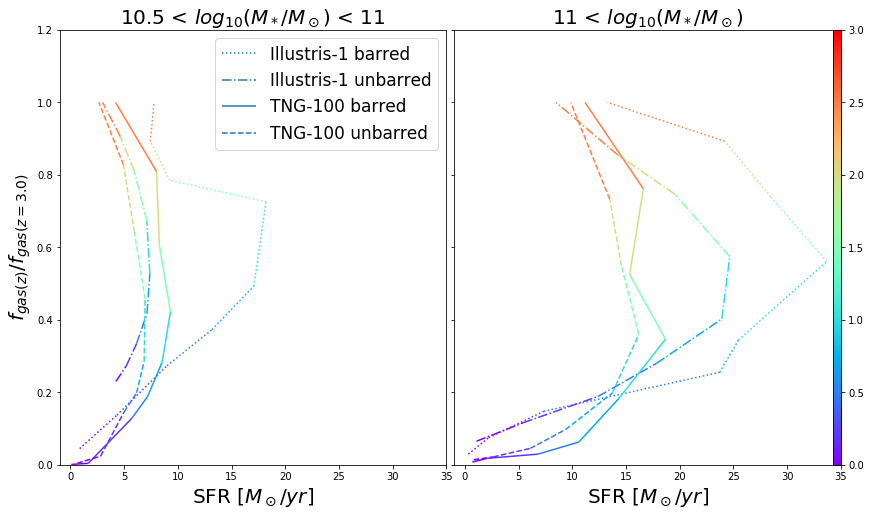

In [94]:
#SFR vs. rs3_GF
norm = plt.Normalize(0, 3)
color = rs

fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(14, 8))

for massBin in range(2):
    lc1 = LineCollection(xyline(il1_SFR_data[0+2*massBin], il1_GF_modify_data[0+2*massBin]), cmap='rainbow', norm=norm, linestyles='dotted', label='Illustris-1 barred')
    lc1.set_array(np.array(color))
    line = ax[massBin].add_collection(lc1)
    
    lc2 = LineCollection(xyline(il1_SFR_data[1+2*massBin], il1_GF_modify_data[1+2*massBin]), cmap='rainbow', norm=norm, linestyles='dashdot', label='Illustris-1 unbarred')
    lc2.set_array(np.array(color))
    line = ax[massBin].add_collection(lc2)
    
    lc3 = LineCollection(xyline(tng_SFR_data[0+2*massBin], tng_GF_modify_data[0+2*massBin]), cmap='rainbow', norm=norm, linestyles='solid', label='TNG-100 barred')
    lc3.set_array(np.array(color))
    line = ax[massBin].add_collection(lc3)
    
    lc4 = LineCollection(xyline(tng_SFR_data[1+2*massBin], tng_GF_modify_data[1+2*massBin]), cmap='rainbow', norm=norm, linestyles='dashed', label='TNG-100 unbarred')
    lc4.set_array(np.array(color))
    line = ax[massBin].add_collection(lc4)
    

    
#     ax[massBin].set_xscale('log')
    ax[massBin].set_xlabel(r'SFR [$M_\odot/yr$]', fontsize=20)
    ax[massBin].set_xlim(-1, 35)
    ax[massBin].set_ylim(0, 1.2)

ax[0].legend(loc = 1, fontsize=17)
ax[0].set_ylabel(r'$f_{gas(z)}/f_{gas(z=3.0)}$', fontsize=20)
ax[0].set_title(r'10.5 < $log_{10}({M_*}/M_\odot)$ < 11', fontsize=20)
ax[1].set_title(r'11 < $log_{10}({M_*}/M_\odot)$', fontsize=20)

# ax[1].text(25, 17, r'Redshift $z$', horizontalalignment='left', verticalalignment='center', rotation='vertical', fontsize=20)

# fig.tight_layout()
axins = inset_axes(ax[1],
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower right',
                   bbox_to_anchor=(0., 0, 1.0, 1.0),    #(x, y, wide, height)
                   bbox_transform=ax[1].transAxes,
                   borderpad=0,
                   )
fig.colorbar(line, cax=axins)
plt.subplots_adjust(wspace = 0.02, hspace =0)

plt.savefig('/Raid0/zhouzb/result_V2/SFR_rs3GF_colorline.pdf')
plt.savefig('./figs/SFR_rs3GF_colorline.png')

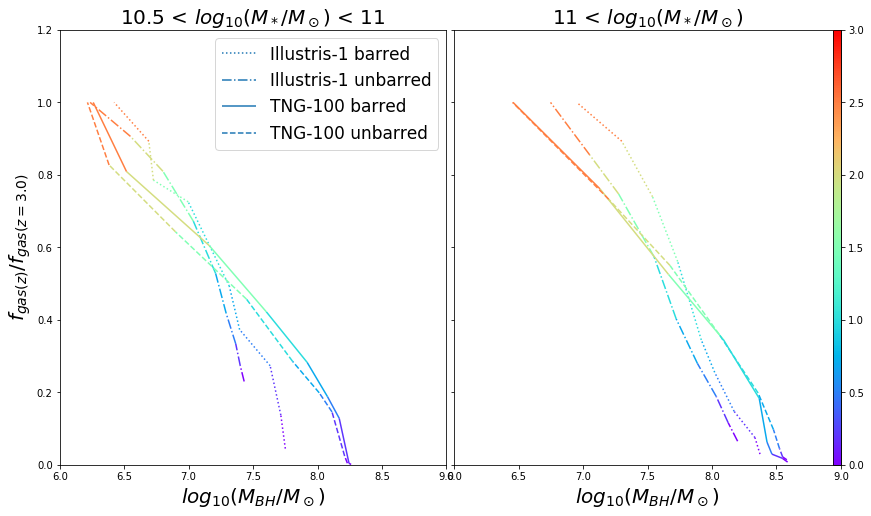

In [86]:
#BHMass vs. rs3_GF
norm = plt.Normalize(0, 3)
color = rs

fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(14, 8))

for massBin in range(2):
    lc1 = LineCollection(xyline(il1_log_BHMass_data[0+2*massBin], il1_GF_modify_data[0+2*massBin]), cmap='rainbow', norm=norm, linestyles='dotted', label='Illustris-1 barred')
    lc1.set_array(np.array(color))
    line = ax[massBin].add_collection(lc1)
    
    lc2 = LineCollection(xyline(il1_log_BHMass_data[1+2*massBin], il1_GF_modify_data[1+2*massBin]), cmap='rainbow', norm=norm, linestyles='dashdot', label='Illustris-1 unbarred')
    lc2.set_array(np.array(color))
    line = ax[massBin].add_collection(lc2)
    
    lc3 = LineCollection(xyline(tng_log_BHMass_data[0+2*massBin], tng_GF_modify_data[0+2*massBin]), cmap='rainbow', norm=norm, linestyles='solid', label='TNG-100 barred')
    lc3.set_array(np.array(color))
    line = ax[massBin].add_collection(lc3)
    
    lc4 = LineCollection(xyline(tng_log_BHMass_data[1+2*massBin], tng_GF_modify_data[1+2*massBin]), cmap='rainbow', norm=norm, linestyles='dashed', label='TNG-100 unbarred')
    lc4.set_array(np.array(color))
    line = ax[massBin].add_collection(lc4)
    

    
#     ax[massBin].set_xscale('log')
    ax[massBin].set_xlabel(r'$log_{10}(M_{BH}/M_\odot)$', fontsize=20)
    ax[massBin].set_xlim(6, 9)
    ax[massBin].set_ylim(0, 1.2)

ax[0].legend(loc = 1, fontsize=17)
ax[0].set_ylabel(r'$f_{gas(z)}/f_{gas(z=3.0)}$', fontsize=20)
ax[0].set_title(r'10.5 < $log_{10}({M_*}/M_\odot)$ < 11', fontsize=20)
ax[1].set_title(r'11 < $log_{10}({M_*}/M_\odot)$', fontsize=20)

# ax[1].text(25, 17, r'Redshift $z$', horizontalalignment='left', verticalalignment='center', rotation='vertical', fontsize=20)

# fig.tight_layout()
axins = inset_axes(ax[1],
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower right',
                   bbox_to_anchor=(0., 0, 1.0, 1.0),    #(x, y, wide, height)
                   bbox_transform=ax[1].transAxes,
                   borderpad=0,
                   )
fig.colorbar(line, cax=axins)
plt.subplots_adjust(wspace = 0.02, hspace =0)

plt.savefig('/Raid0/zhouzb/result_V2/BHmass_rs3GF_colorline.pdf')
plt.savefig('./figs/BHmass_rs3GF_colorline.png')

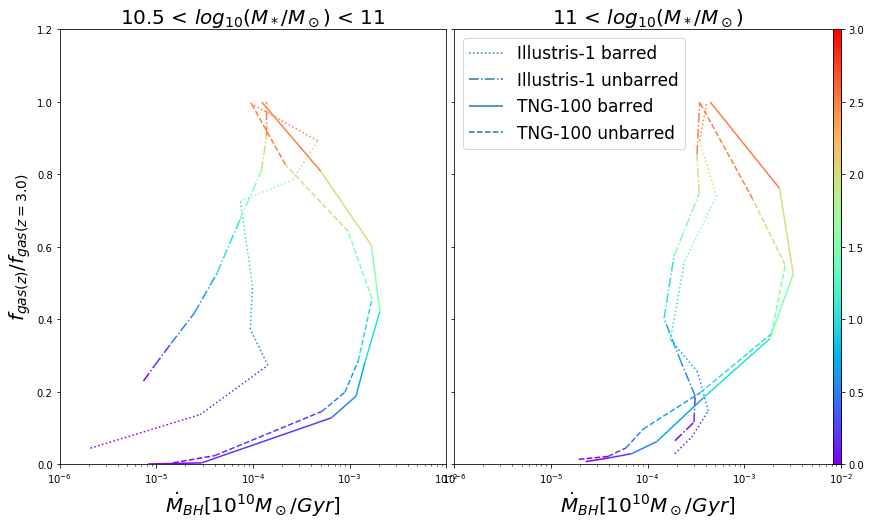

In [93]:
#BHdot vs. rs3_GF
norm = plt.Normalize(0, 3)
color = rs

fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(14, 8))

for massBin in range(2):
    lc1 = LineCollection(xyline(il1_BHdot_data[0+2*massBin], il1_GF_modify_data[0+2*massBin]), cmap='rainbow', norm=norm, linestyles='dotted', label='Illustris-1 barred')
    lc1.set_array(np.array(color))
    line = ax[massBin].add_collection(lc1)
    
    lc2 = LineCollection(xyline(il1_BHdot_data[1+2*massBin], il1_GF_modify_data[1+2*massBin]), cmap='rainbow', norm=norm, linestyles='dashdot', label='Illustris-1 unbarred')
    lc2.set_array(np.array(color))
    line = ax[massBin].add_collection(lc2)
    
    lc3 = LineCollection(xyline(tng_BHdot_data[0+2*massBin], tng_GF_modify_data[0+2*massBin]), cmap='rainbow', norm=norm, linestyles='solid', label='TNG-100 barred')
    lc3.set_array(np.array(color))
    line = ax[massBin].add_collection(lc3)
    
    lc4 = LineCollection(xyline(tng_BHdot_data[1+2*massBin], tng_GF_modify_data[1+2*massBin]), cmap='rainbow', norm=norm, linestyles='dashed', label='TNG-100 unbarred')
    lc4.set_array(np.array(color))
    line = ax[massBin].add_collection(lc4)
    

    
    ax[massBin].set_xscale('log')
    ax[massBin].set_xlabel(r'$\dot{M}_{BH}[10^{10} M_\odot / Gyr]$', fontsize=20)
    ax[massBin].set_xlim(0.000001, 0.01)
    ax[massBin].set_ylim(0, 1.2)

ax[1].legend(loc = 2, fontsize=17)
ax[0].set_ylabel(r'$f_{gas(z)}/f_{gas(z=3.0)}$', fontsize=20)
ax[0].set_title(r'10.5 < $log_{10}({M_*}/M_\odot)$ < 11', fontsize=20)
ax[1].set_title(r'11 < $log_{10}({M_*}/M_\odot)$', fontsize=20)

# ax[1].text(25, 17, r'Redshift $z$', horizontalalignment='left', verticalalignment='center', rotation='vertical', fontsize=20)

# fig.tight_layout()
axins = inset_axes(ax[1],
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower right',
                   bbox_to_anchor=(0., 0, 1.0, 1.0),    #(x, y, wide, height)
                   bbox_transform=ax[1].transAxes,
                   borderpad=0,
                   )
fig.colorbar(line, cax=axins)
plt.subplots_adjust(wspace = 0.02, hspace =0)

plt.savefig('/Raid0/zhouzb/result_V2/BHdot_rs3GF_colorline.pdf')
plt.savefig('./figs/BHdot_rs3GF_colorline.png')